 # Table of Contents

How to read this notebook:
> * [Guidelines](#guidelines)

Skip directly to the question answers section:
> * [Chapter QA](#QASection)

Read by Chapters:
> * [Introduction](#introduction)
> * [1. Understanding the Dataset](#chapter1)
>> * [1.1 Investigate Categorical Columns](#section1.1)
>> * [1.2 Investigate Numeric Columns](#section1.2)
>> * [1.3 Visualize Data](#section1.3)
>> * [Dealing With Big Data](#chunks)
>> * [1.4 Memory Optimization](#section1.4)
>>> * [1.4.1 Numeric Memory Optimization](#section1.4.1)
>>> * [1.4.2 Categorical Memory Optimization](#section1.4.2)
>> * [1.5 Data Validation and Independent Analysis](#section1.5)
>>> * [1.5.1 Convert to datetime[ns]](#section1.5.1)
>>> * [1.5.2 Convert bool to int8](#section1.5.2)
>>> * [1.5.3 Validating Categorical Data(Independent Analysis)](#section1.5.3)
>>> * [1.5.4 Validating Numeric Data(Independent Analysis)](#section1.5.4)
>> * [1.6 Data Summarization](#section1.6)
> * [2. Data Cleaning and Imputation](#section2)
>> * [2.1 Addressing Missing Data](#section2.1)
>>> * [2.1.1 Dropping Missing Values ](#section2.1.1)
>>> * [2.1.2 Addressing Categorical NaN values](#section2.1.2p1)
>>> * [2.1.2 Addressing Categorical NaN values](#section2.1.2p2)
>> * [2.2 Converting DataFrame into Chunks](#section2.2)
> * [3. Data Visualization](#chapter3)
> * [Answering the Questions](#QASection)

# Guidelines <a class='anchor' id='guidelines'></a>

This section is dedicated to making the reader's have an easy time while going through this notebook.

- You can navigate to the content you desire to know about by simpy tapping the chapters provided in the table of contents.
- It would be in the reader's best interests to not uncomment the commented lines of code as you will come across several lines of commented code to provide insight on why I did what I did.
- To ensure smooth understanding of the contents, please read the markdowns as they are quite interactive.

# Introduction

We are dealing with the generative AI models uploaded to the most popular open source library **HuggingFace**.

The aim of this analysis is to provide an in-depth insight on the models in the dataframe that stores data on the said models. This is for education purposes. So, without further ado, let's get started.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
import pandas as pd
from datetime import datetime

In [ ]:
df = pd.read_json('/kaggle/input/hugging-face-models/data.json')

In [ ]:
df.head(10)

* Olders modified model?
* Latest modified model?
* Top Ranking, based on: downloads, likes
* average downloads, likes per pipeline
* Top Ranking of users and enterpises and combined

# EDA: Exploratory Data Analysis
We need to review and clean the data to:
- Derive insights
- Generate Hypotheses

# 1. Understanding the Dataset: <a class='anchor' id='chapter1'> </a>

In [ ]:
df.head()

In [ ]:
## Check shape:
df.shape

In [ ]:
## Generate summary of the data:
df.info()

### Inference: 
It would seem that there are a lot of missing values in our data. We need to address them but lets familiarize ourselves with the data a little more.

- First, the model-id is of type object with zero null values.
- The pipeline is of type object with null values equivalent to almost half of the dataset.
- The downloads is of type int64 with zero null values.
- The likes of of type int64 with zero null values.
- The author id is of type object with a few null values.
- The author name is of type object with a few null values.
- The author_isPro is of type bool with zero null values.
- The last modified is of type object with no null values.

There are 6 categorical columns, 2 numeric columns and a single boolean column.

### What we need to do:
Address categorical columns:
- Identify how many data points we have in each category
- Change the lastModified object datatype to datetime datatype

Address numeric columns:
- Address the null values
- Find a distribution

## 1.1 Investigate Categorical Columns: <a class='anchor' id='section1.1'></a>

In [ ]:
df.columns

In [ ]:
## Check the model-id category for similar model-ids
df['model_id'].nunique

In [ ]:
### Inference:
'''The idea is that there should not be any duplicates in the model_id column.
Therefore, it's better to drop the duplicates from the id column if there are any.
Since there aren't any duplicates, it's fine if we don't do this line of code.
I just decided I should add it here anyway.
'''
df['model_id'].drop_duplicates()

In [ ]:
## Check for the number of datapoints in the pipeline categorical column
df['pipeline'].value_counts()

In [ ]:
## There are categories in the pipeline column. Let's calculate the number of categories
len(df.pipeline.value_counts())

## Inference:
There are a total of 40 unique categories in our pipeline column. Let's continue.

In [ ]:
## Check for the number of data points in the author id categorical column
df['author_id'].value_counts()

## Inference:
There are 117514 categories in our author_id column.

In [ ]:
## Check for the number of data points in the name categorical column
df['author_name'].value_counts()

## Inference:
There are 105613 categories in our author_name column. 

### Strange:
There is a mismatch in the length of the author_names and the author_ids.
This is something to take note of. What might be happening here? My hypotheses:
- As the number of author names is lower than the number of author ids', the same author could have multiple ids.
- As there is a mismatch, it is possible that there are null values in the author ids that is causing this phenomenon.

Now then, let's check for the second case here.

In [ ]:
df['author_name'].isna().sum(), df.author_id.isna().sum()

It would seem that our hypothesis holds true for three values. Let's check our first hypothesis.

In [ ]:
df.groupby('author_name')['author_id'].value_counts()

## Inference
Although not aesthetically pleasing, we can take away from the above information that YES! There are authors having the same name but multiple ids, as the number is more than 1 all over

In [ ]:
## Check for the number of datapoints in the author type categorical column
df['author_type'].value_counts()

## Inference:
There are only 2 categories in our author_type column

## 1.2 Investigate numerical columns: <a class='anchor' id='section1.2'></a>

In [ ]:
df.describe()

## Inference:
It's hard to understand just numbers without visualizing them. 

However, what can be taken from here is that the highest number of downloads is 72409331 and the lowest is 0. 
Using box plots for looking at the quartiles is not intuitive in this case as above 50 percent of the models have had 0 downloads!
75% of the data has had 3 downloads!

In case of likes, almost 75% has had 0 likes while a model has received 9637 likes.
Moreover, the total number of likes is 412507 so it can be said that there are popular models out there. But most of the models have not received any likes at all.

Let's visualize the distribution.

## 1.3 Visualizing the distribution of our numeric data <a class='anchor' id='section1.3'></a>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# sns.histplot(data=df, x='downloads')
# plt.show()

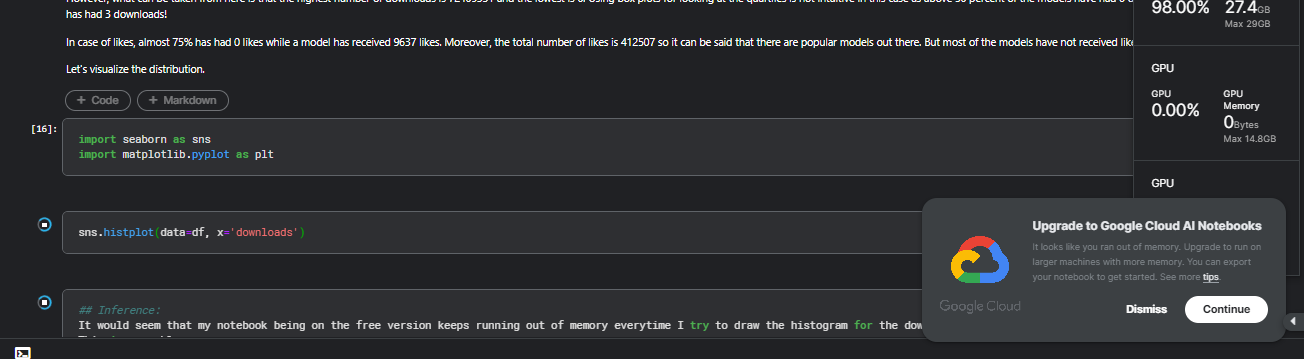

In [ ]:
# sns.histplot(data=df, x='likes')
# plt.show()

## Inference: 
It would seem that my notebook being on the free version keeps running out of memory everytime I try to draw the histogram for the downloads and likes...
This is a good thing as this will enable us to deal with this problem in the earlier stage of the data analysis.

It is also a common problem when working with big data. Since our data engineers failed to reduce the data into chunks we the data scientists need to make the required adjustments here.
Let's deal with this here and now. 
We will write a python function here:

## Dealing with big data: Splitting Data into Chunks <a class='anchor' id='chunks'></a>

In [ ]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

In [ ]:
chunks = split_dataframe(df=df)

In [ ]:
len(chunks)

## Inference

Okay, so our data can be chunked... actually it has already been chunked.. but we are not going to use this yet. We will implement a few tricks on our original dataframe to optimize our memory usage first, then split them into exactly 2 or 4 chunks!

First, let's get the information on our original dataframe again.


## 1.4 Memory Optimization <a class='anchor' id='section1.4'></a>

In [ ]:
df.info()

Let's say we are only interested in the dtypes column

In [ ]:
df.dtypes

### 1.4.1 Numeric Data Memory Optimization <a class='anchor' id='section1.4.1'></a>
Let's check our numerical data where both are int64

In [ ]:
print(f"Max likes: {df['likes'].max()}, Max downloads: {df['downloads'].max()}")

In [ ]:
df['likes'].memory_usage(index=False, deep=True)

## Inference
int32 would be valid for our downloads data while int16 would be better for our likes data

As we are going to perform operations that will permanently change our data, it would be in our best interests to create a copy of our data and do the operations on that copy

In [ ]:
optimized_df = df.copy()
optimized_df.info()

In [ ]:
optimized_df['likes']=optimized_df['likes'].astype('int16')
optimized_df['likes']

In [ ]:
optimized_df['likes'].memory_usage(index=False, deep=True)

## Inference:
We have successfully reduced our memory usage of the likes series from 3300056 to 825014

In [ ]:
optimized_df['downloads'].memory_usage(index=False, deep=True)

In [ ]:
optimized_df['downloads'] = df['downloads'].astype('int32')
optimized_df['downloads']

In [ ]:
optimized_df['downloads'].memory_usage(index=False, deep=True)

## Inference:
We have successfully reduced our memory usage from 3300056 to 1650028

In [ ]:
df2 = optimized_df.copy()

In [ ]:
df2.info()

Let's compare the memory usage of our second dataframe with that of our first dataframe

In [ ]:
df.info(verbose=False, memory_usage=True)

In [ ]:
df2.info(verbose=False, memory_usage=True)

### 1.4.2 Categorical Data Memory Optimization <a class='anchor' id='section1.4.2'></a>

In [ ]:
df2.dtypes

In [ ]:
df2[['model_id','pipeline','author_id','author_name','author_type']].astype('category')

## Inference
It seems that the None values has now turned into NaN which makes sense.

Notice how I only manipulated 5 columns and not all 6.

This is because the series for lastModified is actually supposed to be a datetime type and not a category. We will get to it soon.

However, it should be noted that it is not wise to convert all the objects into categorical data as we will see below that it raises the memory usage by 2 times! from 21.6 MB to 40.4MB

In [ ]:
optimized_df2 = df2.copy()
optimized_df2[['model_id','pipeline','author_id','author_name','author_type']] = optimized_df2[['model_id','pipeline','author_id','author_name','author_type']].astype('category')

In [ ]:
optimized_df2.info()

## Inference:
So, which objects should we transform into categories?
We already looked into the number of categories in each column in the first part of our EDA.
We noticed that there are only 2 categories in our author_type column and 40 categories in our pipeline column which might seem like a lot but not really when compared to the length of our dataframe.
However, the remaining 4 columns showed categories but they were mapped one-one most of the time. It'd be wiser for us not to convert those data into categories.

In [ ]:
optimized_df2 = df2.copy()
optimized_df2.info()

In [ ]:
optimized_df2['pipeline'] = optimized_df2['pipeline'].astype('category')

In [ ]:
optimized_df2.info()

In [ ]:
optimized_df3 = optimized_df2.copy()
optimized_df2.info()

In [ ]:
optimized_df3['author_type'] = optimized_df3['author_type'].astype('category')
optimized_df3.info()

## Inference:
We can notice easily that our memory usage has reduced from 25.6 MB to 16.1 MB. Let's make it even clearer below.

In [ ]:
df.info(verbose=False, memory_usage=True)

In [ ]:
df2.info(verbose=False, memory_usage=True)

In [ ]:
optimized_df2.info(verbose=False, memory_usage=True)

In [ ]:
optimized_df3.info(verbose=False, memory_usage=True)

In [ ]:
df3 = optimized_df3.copy()

In [ ]:
df3.info()

### Validation behind not converting author name, author id and model id as category 

As I have said that it wouldn't be intuitive to convert the object types that don't have a lot of categories in them to the category data type intuitively, it would be in my best interest to prove myself. I have done so below:

In [ ]:
df['author_name'].value_counts()

In [ ]:
df['author_id'].value_counts()

In [ ]:
df3['author_name'].memory_usage(), df3['author_id'].memory_usage()

In [ ]:
df3['author_name'].astype('category').memory_usage(), df3['author_id'].astype('category').memory_usage()

In [ ]:
df3['model_id'].memory_usage('category'), df3['model_id'].astype('category').memory_usage()

## Inference
We have performed the following memory optimization tasks on our dataframe:
   1. We have optimized our numeric datatypes.
   2. We have optimized our categoric datatypes.
    
What we will do moving forward:
   1. We will drop columns we are not interested in.
   2. We will analyze our NaN values



What we have done so far has pertained to implementing techniques that would allow us to smartly allocate our memory. This is not all that we can do as we are yet to address the NaN values. But we can't just address the NaN values until we are confident we have familiarized ourselves with the data completely. We can also drop columns that we are not interested in, in order to optimize our memory. Since we do not have any particular goals yet, we will not drop any columns and keep the data as is.

Our next step is data validation where we will make sure that our data is accurately displayed

## 1.5 Data Validation <a class='anchor' id='section1.5'></a>

We want to make sure that our data-types are as expected before we move too far  in our data analysis.



In [ ]:
df3.info()

In [ ]:
df3.dtypes

The last modified should always be of dtype dataetime. Let's inspect it

### 1.5.1 Convert to datetime[ns] <a class='anchor' id='section1.5.1'></a>

In [ ]:
df3.lastModified.head()

It can be converted to dtype datetime[ns]

In [ ]:
df3['lastModified'].head()

In [ ]:
df3['lastModified'].memory_usage()

In [ ]:
# It is in YY-MM-DD format. It also has time in the 24 hour format, we used errors='coerce' to get rid of the date times with missing values 
df3_datetime = df3.copy()
df3_datetime['lastModified'] = pd.to_datetime(df3_datetime['lastModified'], errors='coerce')
df3_datetime['lastModified'].head()

In [ ]:
# check memory usage
df3_datetime['lastModified'].memory_usage()

In [ ]:
df3_datetime.info()

In [ ]:
df4 = df3_datetime.copy()
df4.info()

## Inference:
It would seem that the datetime column has not impacted our memory usage at all as it should be. 



### 1.5.2 Convert bool to int8 <a class='anchor' id='section1.5.2'></a>

Let's convert our boolean data into integers then convert it to int8 datatype which will reduce the memory usage dramatically. let's convert our boolean data into integers then convert it to int8 datatype which will reduce the memory usage dramatically.

In [ ]:
df_bool_toint = df4.copy()
df_bool_toint.dtypes

In [ ]:
df4.author_isPro.memory_usage()

In [ ]:
df_bool_toint['author_isPro'] = df_bool_toint['author_isPro'].astype('int8')
df_bool_toint.dtypes

In [ ]:
df_bool_toint.author_isPro.memory_usage()

In [ ]:
df5 = df_bool_toint.copy()

In [ ]:
df5.info()

### 1.5.3 Validating Categorical Data <a class='anchor' id='section1.5.3'></a>

In [ ]:
df5.dtypes

In [ ]:
df5[['pipeline','author_type']].head()

In [ ]:
## We will perform an example here, let's check our categorical column pipeline to see if our pipeline is limited to text-classification and image-classification, which it obviously isn't but just as an example
pipeline_filter=df5['pipeline'].isin(['text-classification','image-classification'])
pipeline_filter

In [ ]:
## Let's filter our values for that:
filtered_df = df5[pipeline_filter]
filtered_df.head()

## Inference:
Since, we still do not have any plan in our minds on what we wish to do with our data let's just keep it as it is




### 1.5.4 Validating numerical data <a class='anchor' id='section1.5.4'></a>

In [ ]:
df.select_dtypes('number').head()

In [ ]:
df5.describe()

In [ ]:
df5.downloads.max()

In [ ]:
df5.downloads.min()

In [ ]:
df5.likes.max()

In [ ]:
df5.likes.min()

In [ ]:
sns.scatterplot(data=df5, y="likes", x='downloads')
plt.show()

## Inference:

It would seem that according to the scatterplot, our likes and downloads are positively correlated for the most part.

We have also gained insight on our data's maximum and minimum values i.e. our validation range.

However, if we observe, we have two new columns when describing our data, one for the datetime and the other for the author_isPro which consists of 1s' and 0s'.

In [ ]:
df6 = df5.copy()

In [ ]:
df6.info()

In [ ]:
# sns.histplot(data=df5, x='downloads')

It would seem that our data is still too large for performing an overall distribution analysis. 
We will re-address this problem once we have addressed the NaN values.

For now let's summarize our data.

## 1.6 Data Summarization <a class='anchor' id='section1.6'></a>

We have performed both numerical and categorical validation of our data. 
Let's summarize our data. 

We will use the `.groupby()` and `.agg()` functions to perform some form of data summarization, maybe even engineer a few new features into our dataframe.

We first select the categorical column that we wish to group by then we chain an aggregating function like `.mean()`, `.median()`,`.mode()`, `.min()`, `.max()`, `.std()`, `.count()`, `.var()` and `.sum()`

We will use `.agg()` when we want to use more than one aggregating functions on the column of interest.


In [ ]:
df6.info()

We have two categorical data to group our data by. Let's make use of these categories first

In [ ]:
df6.groupby('author_type').describe()

In [ ]:
df6.groupby('pipeline').describe()

## Inference:
We have successfully created a summary of our data.
However, we could dive deeper into this topic. Let's apply some aggregating functions

In [ ]:
# df6.agg(['mean','std'])

The `.agg()` function will automatically apply the mean() and std() function to our numerical columns
Let's implement some aggregating functions to our downloads and likes columns.

In [ ]:
# df6.agg({"downloads":["mean", "std"], "likes":["median"]})

In [ ]:
# # Combining .agg() and .groupby()

# df6.groupby("pipeline").agg(
#     mean_downloads_by_pipeline = ("downloads", "mean"),
#     std_downloads_pipeline = ("downloads", "std"),
#     median_likes_by_pipeline = ("likes", "median"),
#     mode_likes_by_pipeline = ("likes", "mode")
# )

In [ ]:
# df6.groupby("author_type").agg(
#     mean_downloads_by_author_type = ("downloads", "mean"),
#     std_downloads_author_type = ("downloads", "std"),
#     median_likes_by_author_type = ("likes", "median"),
#     mode_likes_by_author_type = ("likes", "mode")
# )

In [ ]:
# sns.boxplot(data=df6, x='pipeline', y='likes')

## Inference:
Our data is not yet ready for summarization it would seem.
We either need to convert our data into chunks or see what happens after we cleanup the NaN values

# 2. Cleaning and Imputation <a class='anchor' id='section2'></a>

Now that we have gotten to know our data better, let's clean and impute our dataframe.

We will
- Address Missing data
- Convert and analyze categorical data
- Handle outliers

## 2.1: Addressing missing data: <a class='anchor' id='section2.1'></a>

Missing data affects distributions. Our data will be less representative of the actual population. It will make us draw incorrect conclusions.

In [ ]:
df6.isna().any()

In [ ]:
df6.isna().sum()

### Inference:
As suspected, there are missing values for four of our variables.


The `pipeline` variable has a lot of missing values while the author_id has 67 and the `author_name` and `author_type` have 70

### 2.1.1 Strategies for addressing missing data: <a class='anchor' id='section2.1.1'></a>
- Drop missing values
    - 5% or less of total values
- Impute mean, median, mode
    - Depends on distribution and context (numerical variables)
- Impute by sub-groups
    - Different groups have different amounts of distribution of variables

### Dropping missing Values:

In [ ]:
df7 = df6.copy()

In [ ]:
df7.info()

In [ ]:
threshold = len(df7) * 0.05
print(threshold)

In [ ]:
cols_to_drop = df7.columns[df7.isna().sum()<=threshold]
print(cols_to_drop)

In [ ]:
df7.dropna(subset=cols_to_drop, inplace=True)

In [ ]:
df7.info()

### Inference: 
We successfully dropped the missing values lower than the threshold.
Now, we filter for the remaining columns.
However, strange as it is, our memory usage skyrocketed to 19.3+ MB!!!

Is this a bug in the pandas library? No, this is because our `RangeIndex` changed to an `Int64Index` index.

Let's fix this.

In [ ]:
df7 = df6.copy()
df7.dropna(subset=cols_to_drop, inplace=True)
df7.info()

In [ ]:
df7 = df7.reset_index(drop=True)
df7.info()

### 2.1.2 Addressing categorical NaN values [Procedure 1] <a class='anchor' id='section2.1.2p1'></a>

We take note that we can neither drop nor impute our missing values when it comes to the pipeline variable as it is of datatype catagory. Therefore, let us predict the missing values using a classification algorithm instead.

We will do so by the following steps:
1. First create a copy of the data and drop all the rows with missing values
2. Train the model with pipeline as the target feature.
3. Use the model thus to predict the missing values from the dataframe with null values.
4. Merge the two dataframes into one.

In [ ]:
!pip install scikit-learn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

In [ ]:
df8 = df7.copy()
df8.dropna(inplace=True)
df8.info()

In [ ]:
df8.head()

### Convert objects and categories to numbers

#### Author_type:

In [ ]:
df8.author_type.memory_usage()

In [ ]:
df8.author_type.value_counts()

In [ ]:
df8.author_type.isna().any()

In [ ]:
df8.author_type = df8.author_type.replace({'user':0, 'org':1})
df8.author_type.memory_usage()

In [ ]:
df8.author_type.info()

In [ ]:
df8.author_type = df8.author_type.astype('int8')
df8.author_type.memory_usage()

In [ ]:
df8.author_type.info()

#### Drop unnecessary columns:

**Author ID**

Reason behind this is as we have already seen before, a single author could have multiple ids. It is unnecessary to make decisions based on the author id when we already have the author name

In [ ]:
df8.drop('author_id', inplace=True, axis=1)
df8.info()

In [ ]:
len(df8.author_name.value_counts())

It would seem that there are 43,460 authors and they are important in determining the pipeline of the model.

The lastModified column isn't as important so we will drop it.

Since the model_id are all unique, intuitively it is possible to draw the conclusion that they will not contribute much to the prediction of which model belongs to which pipeline. To reduce the stress on our RAM, let's drop it as well.

In [ ]:
df8.drop(['model_id','lastModified'], inplace=True, axis=1)

In [ ]:
df8.info()

Let's finally convert the dtype auth_name to int dtype using pd.get_dummies

In [ ]:
# df8_dummies = df8['author_name']
# df8_dummies = pd.get_dummies(df8.author_name)

In [ ]:
# df8 = pd.concat([df8,df8_dummies], axis='columns')

We keep losing precious RAM memory when we try to do this. Best not try this until we have converted our data into chunks

In [ ]:
df8.drop('author_name', inplace=True, axis=1)

In [ ]:
df8.info()

In [ ]:
# X = df8.drop('pipeline', axis=1).values
# y = df8['pipeline'].values

# X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                    test_size=0.2,
#                                                    random_state=0)

# forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
#                                 max_features=0.6, min_samples_leaf=3, n_jobs=-1)

# forest.fit(X_train, y_train)

# y_pred_train - forest.predict(X_train)
# y_pred = forest.predict(X_test)

# y_pred_proba = forest.predict_proba(X_test)

# accuracy_train = accuracy_score(y_train, y_pred_train)
# accuracy_test = accuracy_score(y_test, y_pred)

# print(f"Accuracy: Train={accuracy_train} Test={accuracy_test}")
# print(f"Log Loss: {log_loss(y_test,y_pred_proba)}")

### Inference:
It seems that our notebook ram will not let us perform this form of analysis either.
This is not unusual but it goes to show just how important it is to allocate memory before getting started with any form of data analytics.

Dropping all the observations with NaN values seem like a luxury now.. but let's follow procedure2 instead which would be more appropriate in our case.

#### 2.1.2 Addressing Missing Categorical Data [Procedure2] <a class='anchor' id='section2.1.2p2'></a>

The reason behind following a second procedure is that, if you put some thought into the matter, it is only natural for models that are older to not have any pipeline. Newer models also might have no pipeline. Therefore, the missing values could easily be filled using `fillna()` by `No-Pipeline` instead of `NaN` thereby solving the issue.

Before filling the missing values however, we should make sure to convert the category type back to object type. We can return it to it's category type once we haved filled the missing values

In [ ]:
df9 = df7.copy()

In [ ]:
df9['pipeline'] = df9['pipeline'].astype('object')

In [ ]:
df9['pipeline']=df9['pipeline'].fillna('no_pipeline')

In [ ]:
df9['pipeline'] = df9['pipeline'].astype('category')

We have solved our missing values problem and now can have a look at our dataframe.

In [ ]:
df9.info()

In [ ]:
df9.isna().any()

## 2.2 Converting DataFrame into Chunks <a class='anchor' id='section2.2'></a>

Finally! The step we have been waiting for. We will convert our DataFrame into chunks before moving further. This is important as we have been facing the problem of being unable to manipulate our data.

Let us define a function to convert our data frame into chunks.

In [ ]:
# input - df: a Dataframe, chunkSize: the chunk size
# output - a list of DataFrame
# purpose - splits the DataFrame into smaller chunks
def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Now, to convert the dataframe into chunks. But let's check the length of our dataframe first.

In [ ]:
len(df9)

Let's try dividing it into 2 chunks and see how it goes.

In [ ]:
chunks = split_dataframe(df=df9, chunk_size=len(df9)//2)

In [ ]:
len(chunks)

In [ ]:
chunked_df1, chunked_df2, chunked_df3 = chunks[0], chunks[1], chunks[2]

In [ ]:
len(chunked_df1), len(chunked_df2), len(chunked_df1) + len(chunked_df2)

In [ ]:
chunked_df1.info()

In [ ]:
chunked_df2.info()

As can be seen from the information displayed, our dataframe has now just over 8.1MB of memory usage. The question is whether or not we will be able to perform EDA on this dataframe. Let us try to visualize the distribution of our data along the downloads and likes.

In [ ]:
# sns.histplot(data=chunked_df1, x='downloads')
# plt.show()

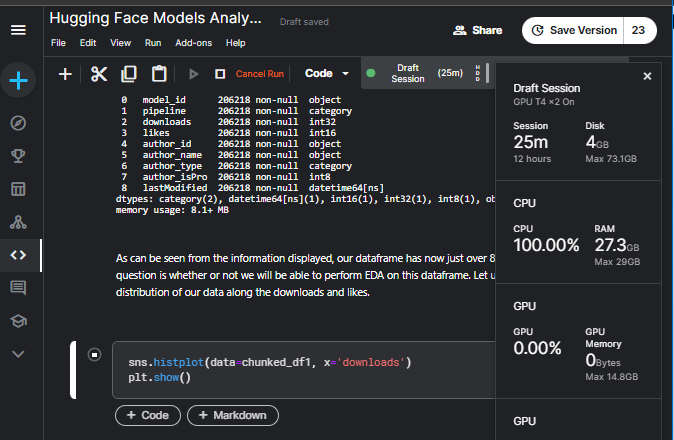

Sadly, the dataframe is still too large. Let us try to chunk it down into even smaller sets. Let's try 5 for now.

In [ ]:
chunks = split_dataframe(df=df9, chunk_size=len(df9)//4)
print(f'DataFrame chunked into: {len(chunks)}')
chunk1, chunk2, chunk3, chunk4, chunk5 = chunks[0], chunks[1], chunks[2], chunks[3], chunks[4]
print(f"""Length of chunk1: {len(chunk1)}\nLength of chunk2: {len(chunk2)}\nLength of chunk3: {len(chunk3)}\nLength of chunk4: {len(chunk4)}\nLength of chunk5: {len(chunk5)}""")

In [ ]:
print(chunk1.info(verbose=False, memory_usage=True))

In [ ]:
print(f'chunk1: {chunk1.info(verbose=False, memory_usage=True)}\n')
print(f'chunk2: {chunk2.info(verbose=False, memory_usage=True)}\n')
print(f'chunk3: {chunk3.info(verbose=False, memory_usage=True)}\n')
print(f'chunk4: {chunk4.info(verbose=False, memory_usage=True)}\n')
print(f'chunk5: {chunk5.info(verbose=False, memory_usage=True)}')

In [ ]:
# sns.histplot(data=chunk1, x='downloads')
# plt.show()

This above line of code will take too long to run. Therefore, we decide to reduce our dataframe into 10 chunks this time! Lets make our decisions faster this time.

In [ ]:
df_chunks = split_dataframe(df=df9, chunk_size=len(df9)//9)
print(f'DataFrame chunked into: {len(df_chunks)}')

In [ ]:
# sns.histplot(data=df_chunks[0], x='downloads')

This above line of code will also take too long to run.

In [ ]:
df_chunks = split_dataframe(df=df9, chunk_size=len(df9)//19)
len(df_chunks)

In [ ]:
# data = df_chunks[0]
# sns.histplot(data=data, x='downloads')

I was expecting this to work this time, but oh well.

In [ ]:
df_chunks = split_dataframe(df=df9, chunk_size=len(df9)//29)
len(df_chunks)

In [ ]:
# data = df_chunks[0]
# sns.histplot(data=data, x='downloads')

This will take long as well.

In [ ]:
df_chunks = split_dataframe(df=df9, chunk_size=len(df9)//99)
len(df_chunks)

In [ ]:
sns.histplot(data=df_chunks[0],x='downloads')

Finally, an output! But sadly, nothing of interest is received here and working on a 100 chunks is impractical!

### Inference:
It would be in our best interest to work only with the columns of interest and not the entire dataframe

# 3. Data Visualization <a class='anchor' id='chapter3'></a>

The reason behind visualizing this late in the data analysis is to make sure that we are working with a clean data. So far, we have addressed the null values and made sure that our dataframe has optimized it's memory usage. We have also developed a deep understanding of our dataframe.

We have drawn the conclusion that drawing a figure of the distribution of numerical variables accross the dataframe is not possible unless we chunk our data.

However, we can visualize our data if we try to visualize by columns of interest which we will be doing in this section of our notebook.

In [ ]:
# Import the dependencies
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df_ = df9.copy()
df_.columns

Let's set the model_id as the index

In [ ]:
df_ = df_.set_index('model_id')

Let us view the number of pipelines per category

In [ ]:
plt.figure(figsize=(20,5))
sns.set(style = 'ticks')
sns.histplot(data=df_, x=df_['pipeline'])
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of pipelines per category')
plt.show()

Much of the pipeline is under the no_pipeline category. Best remove it to get a sharper intuition on the distribution of pipelines per category.

In [ ]:
df_pipeline_only = df_[~df_['pipeline'].str.contains('no_pipeline')] 

In [ ]:
plt.figure(figsize=(20,5))
sns.set(style = 'ticks')
sns.histplot(data=df_pipeline_only, x=df_pipeline_only['pipeline'])
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of pipelines per category')
plt.show()

In [ ]:
# Check the kernel density element using the kde plot
plt.figure(figsize=(20,5))
sns.set(style = 'ticks')
sns.histplot(data=df_pipeline_only, x=df_pipeline_only['pipeline'], kde=True)
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of pipelines per category')
plt.show()

In [ ]:
# Check the estimated cumulative density function using the ecdf plot
width = 20
height = 8
sns.set(rc = {'figure.figsize':(width,height)})
sns.set(style = 'ticks')
sns.displot(data=df_pipeline_only, x=df_pipeline_only['pipeline'], kind='ecdf')
plt.xticks(rotation=90)
plt.grid()
plt.title('Number of pipelines per category')
plt.show()

### Inference:
The categories with the highest number of pipelines are: 

    1. Text classification
    2. Text generation
    3. Reinforcement Learning 

Let's view the percentage of the pipelines having above or equal to 5000 downloads.

In [ ]:
threshold = 10000
df_filtered_pipeline = df_pipeline_only[df_pipeline_only['downloads']>=threshold]
df_filtered_pipeline = df_filtered_pipeline[['pipeline','downloads']]
data = df_filtered_pipeline.pipeline.value_counts()
plt.figure(figsize=(20,20))
palette = sns.color_palette('colorblind')
plt.pie(data, autopct = '%1.1f%%', labels=data.keys(), rotatelabels=True)
plt.legend()
plt.show()

Now, let us view the downloads per pipel

In [ ]:
df_pipeline_downloads = df_[['downloads','pipeline']]
df_pipeline_downloads.head(5)

In [ ]:
sns.set(style='ticks')
plt.figure(figsize=(20,5))
sns.barplot(data=df_pipeline_downloads, x='pipeline', y='downloads')
plt.xticks(rotation=90)
plt.title('Downloads per Pipeline')
plt.grid()
plt.show()

### Inference:
 - It's only natural that the models' without pipelines are not downloaded. We can draw the conclusion here that, people find pipelines really helpful and require that there are pipelines available so that they can work with those models.
 - The most trending pipeline is the voice activity detection pipeline followed by the zero shot image classification pipeline.

Let's check whether pro authors' have more downloads or not

# Answering the questions <a class="anchor"  id="QASection"></a>

### Are we able to answer the questions yet?
- Oldest modified model?
- Latest modified model?
- Top Ranking, based on: downloads, likes
- average downloads, likes per pipeline
- Top Ranking of users and enterpises and combined

This is easy and does not need much EDA. Let's solve these one at a time

In [ ]:
df_investigation = df7.copy()

In [ ]:
df_investigation.info()

### Q: Oldest modified model?
A: Yuhang94/jitsimeet

In [ ]:
### Oldest modified model:
df_investigation.lastModified.min()

In [ ]:
df_investigation[df_investigation['lastModified'] == '2014-08-10 19:35:46']

In [ ]:
df_investigation[df_investigation['lastModified'] == '2014-08-10 19:35:46'].model_id

### Q: Lastest modified model?
A: hkivancoral/hushem_5x_deit_base_sgd_00001_fold5

In [ ]:
df_investigation.lastModified.max()

In [ ]:
df_investigation[df_investigation.lastModified == '2023-11-27 02:59:07']

In [ ]:
df_investigation[df_investigation.lastModified == '2023-11-27 02:59:07'].model_id

### Q: Top Ranking based on Downloads, Likes

A: This requires a few steps, but it can be done in one step. Our target is to determine the top ranked model based on downloads and likes individually and combined. To satisfy the first requirement we will determine the top by determining the maximum of both. Then create a filter and subset the dataframe according to the max values. Once done determine the `model_id`. In order to satisfy the second, we will use the `.groupby()` function.

In [ ]:
df_investigation['downloads'].max(), df_investigation['likes'].max()

In [ ]:
downloads_filter = df_investigation['downloads'] == 72409331
likes_filter = df_investigation['likes'] == 9637

In [ ]:
### Top based on downloads:
df_investigation[downloads_filter]

In [ ]:
df_investigation[downloads_filter].model_id

In [ ]:
### Top based on likes:
df_investigation[likes_filter]

In [ ]:
df_investigation[likes_filter].model_id

`Solution`: 
    
    Top ranked model based on downloads: jonatasgrosman/wav2vec2-large-xlsr-53-english
    Top ranked model based on likes: runwayml/stable-diffusion-v1-5

In [ ]:
### Top based on both downloads and likes
top_rankers = df_investigation.groupby(by=['downloads','likes'], sort=False)['model_id'].max()
top_rankers.head()

`Solution:`

    `Top ranked based on both downloads and likes: jonatasgrosman/wav2vec2-large-xlsr-53-english`

This can be done in a roundabout fashion as I have demonstrated below:

We will add a new column called the combined score in order to solve this problem.

In [ ]:
df_investigation['combined_score'] = df_investigation['downloads'] + df_investigation['likes']
df_investigation.info()

In [ ]:
# Find the index of the row with the highest combined score:
max_idx = df_investigation['combined_score'].idxmax()
max_idx

In [ ]:
top_pipeline_row = df.loc[max_idx]
print("Top ranked:")
top_pipeline_row

In [ ]:
sorted_pipelines = df_investigation.sort_values(by=['downloads', 'likes'], ascending=False)
top_pipeline = sorted_pipelines.iloc[0]
print('Top-ranked Pipeline:')
print(top_pipeline)

### Q: Average downloads, likes per pipeline

In [ ]:
df_investigation['downloads'].mean(), df_investigation['likes'].mean()

#### A: 
Average downloads per pipeline: 1367.5553648193543

Average likes per pipeline: 1.1087099363054236

Which is also evident from the description of the dataframe below

In [ ]:
df_investigation[['downloads','likes']].describe()

### Q: Average downloads and likes per pipeline?

A: 0.002150728398149306

In [ ]:
df_investigation.groupby(by=['downloads','likes'])['pipeline'].value_counts().mean()

### Q: Top Ranking of users and enterpises and combined

In [ ]:
df_investigation.info()

Upon having performed EDA, we understand that users and enterprises are available as `users` and `org` under the `author_type` variable. But let's do that again for context.

In [ ]:
df_investigation.author_type.value_counts()

As can be seen there are 357839 users and 54598 organizations. Our goal is to determine the top ranked user and organizer.

Since we were not told on what parameter we should determine our top ranked user and organizer, lets determine the users and enterprises that had the maximum amount of downloads and likes.

In [ ]:
df_investigation[df_investigation['author_type']=='user']['combined_score'].idxmax()

In [ ]:
df_investigation.loc[0]

`Solution`: It seems that our top scorer when it comes to the combined score of downloads and likes is the user under the name: `Jonatas Grosman`

In [ ]:
df_investigation[df_investigation['author_type']=='org']['combined_score'].idxmax()

In [ ]:
df_investigation.loc[1]

`Solution`: It would seem that our top scorer when it comes to the enterprise on the both the combined scores is: `OpenAI`

`Solution:` So, who came out on top individually? Obviously the user as the combined score is greater in his case.